In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("231214_cytoplasm_all.csv")
experiments = df['experiment'].unique()
experiments_treatments_dict = {name: group["treatment"].unique().tolist() for name, group in df.groupby("experiment")}
experiments_cellline_dict = {name: group["cell_line"].unique().tolist() for name, group in df.groupby("experiment")}
measures = ["na1","na2","nt1","nt2","ntm","fa1","fa2","ft1","ft2","ftm","nint","fint","normrr"]

In [4]:
# Step 1 
def subsetDF(df, experiment, cell_line=None, treatment=None):

    if cell_line is not None:
        criteria = (df['experiment'] == experiment) & (df['cell_line'] == cell_line)
    elif treatment is not None: 
        criteria = (df['experiment'] == experiment) & (df['treatment'] == treatment)
    subset_df = df[criteria].reset_index(drop=True)
    return subset_df

#sdf = subsetDF(df, 'glytcafao',treatment='2DG')
# sdf = subsetDF(df, 'glytcafao',treatment='iodoacetic acid')
sdf = subsetDF(df, 'glytcafao',treatment='sodium arsenite')

In [5]:
# step 1 standardize the features 
# before standardization 
sdf['na1'].mean() # not 0
sdf['na1'].var() # not 1
# standardization 
scaler = StandardScaler()
sd_df = scaler.fit_transform(sdf[measures])
# the standardized 
sd_df[:, 0].mean()
sd_df[:, 0].var()

0.9999999999999998

In [6]:
# step 2: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sd_df)
eigenvalues = pca.explained_variance_ratio_
eigenvalues

array([0.37964656, 0.2224507 ])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Can first 2 PCs make a good classifier?
y = sdf["cancer"]
y = [1 if y[i] == "yes" else -1 for i in range(len(y))]
X = principalComponents
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
# Make predictions
y_pred = log_reg.predict(X_test)
y_pred_svm = svm.predict(X_test)
# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
#print("Classification Report:\n", classification_report(y_test, y_pred))
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
#print("Classification Report:\n", classification_report(y_test, y_pred_svm))

print(f'Coefficients of the first 2 PCs: {log_reg.coef_[0]}')

Logistic Regression Accuracy: 0.69923273657289
Linear SVM Accuracy: 0.740153452685422
Coefficients of the first 2 PCs: [1.51431921 0.36365993]


In [8]:
pca = PCA(n_components=10) 
X = pca.fit_transform(sd_df)
from sklearn.feature_selection import SelectKBest, f_classif

# Apply feature selection on the PCA-transformed data
## SelectKBest: This function selects the best k features based on their scores from a provided scoring function. \
            # It keeps the top k features that have the highest scores.
## f_classif: This is an ANOVA F-value between label/feature for classification tasks. \
## The F-value scores indicate the degree of linear dependency between the feature and the class label.
# Select PCs 
selector = SelectKBest(f_classif, k=2)  
X_selected = selector.fit_transform(X, y)
# Train a classifier on selected PCs
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy}')
selected_indices = selector.get_support(indices=True)
selected_pcs = [f'PC{i+1}' for i in selected_indices]
print(f'Selected PCs: {selected_pcs}')
print(f'Coefficients of the selected PCs: {classifier.coef_[0]}')
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# select original features 
selector = SelectKBest(f_classif, k=2) 
X_selected = selector.fit_transform(sd_df, y)
# Train a classifier on selected original features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy}')
selected_indices = selector.get_support(indices=True)
selected_vars = [f'{measures[i]}' for i in selected_indices]
print(f'Selected Variables: {selected_vars}')
print(f'Coefficients of the selected original features: {classifier.coef_[0]}')
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Train a classifier on all original features
X_train, X_test, y_train, y_test = train_test_split(sd_df, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy}')
print(f'All Variables: {measures}')
print(f'Coefficients of original features: {classifier.coef_[0]}')
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Cancer = 1, no cancer = -1

Logistic Regression Accuracy: 0.8342710997442455
Selected PCs: ['PC1', 'PC4']
Coefficients of the selected PCs: [ 0.75916708 -1.20242396]
Linear SVM Accuracy: 0.8603580562659846
Logistic Regression Accuracy: 0.7539641943734016
Selected Variables: ['na1', 'na2']
Coefficients of the selected original features: [4.46302436 6.43243276]
Linear SVM Accuracy: 0.767774936061381
Logistic Regression Accuracy: 0.8966751918158568
All Variables: ['na1', 'na2', 'nt1', 'nt2', 'ntm', 'fa1', 'fa2', 'ft1', 'ft2', 'ftm', 'nint', 'fint', 'normrr']
Coefficients of original features: [ 2.25147278  1.67914893 -1.36860729 -3.10346031  6.60364779 -0.44703613
  0.44704495  3.00426174  0.87573325 -2.19941967  1.35926085 -0.04111826
  1.14836259]
Linear SVM Accuracy: 0.9130434782608695


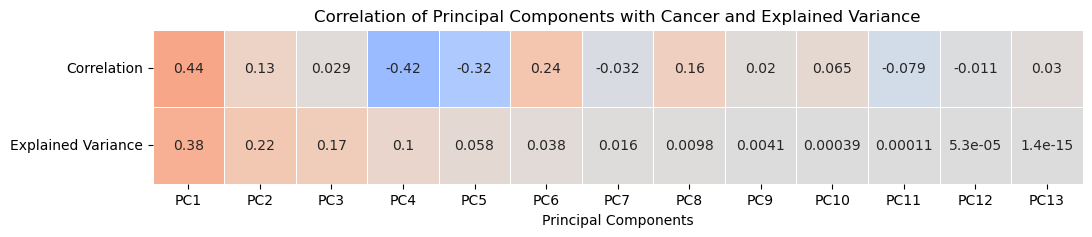

In [9]:
# The correlation of PCs to Y
n_components = 13
pca = PCA(n_components=n_components) 
X = pca.fit_transform(sd_df)
pc_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X, columns=pc_columns)
df_pca['target'] = y
correlation_matrix = df_pca.corr()
# Extract the correlation of each PC with the target
pc_target_correlation = correlation_matrix.loc['target', correlation_matrix.columns != 'target']

explained_variance = pca.explained_variance_ratio_
combined_data = pd.DataFrame({
    'Correlation': pc_target_correlation.values,
    'Explained Variance': explained_variance
}).T
combined_data.columns = [f'PC{i+1}' for i in range(combined_data.shape[1])]
# Plot the correlation using sns.heatmap
plt.figure(figsize=(12, 2))
sns.heatmap(combined_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, linewidths=0.5)
plt.title('Correlation of Principal Components with Cancer and Explained Variance')
plt.xlabel('Principal Components')
plt.show()

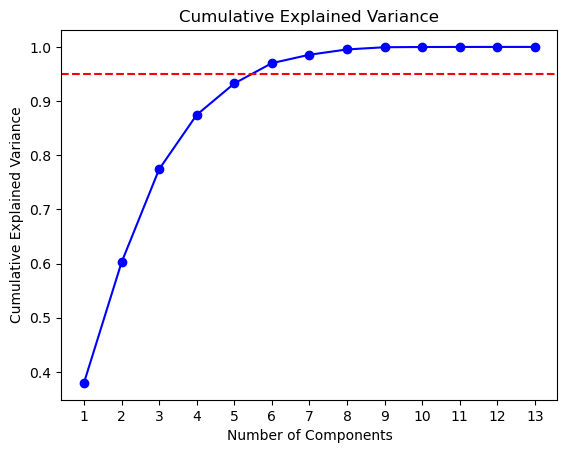

In [10]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
x_values = np.arange(1, len(cumulative_explained_variance) + 1)
plt.plot(x_values, cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(x_values)
# Optionally, add a horizontal line to mark a specific threshold, e.g., 95% variance explained
threshold = 0.95
plt.axhline(y=threshold, color='r', linestyle='--')
plt.show()

In [30]:
df_pca_t_test = df_pca[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'target']]
df_pca_t_test_cancer = df_pca_t_test[df_pca_t_test['target'] == 1]
df_pca_t_test_nocancer = df_pca_t_test[df_pca_t_test['target'] == -1]
import scipy.stats as stats
t_stat, p_value = stats.ttest_ind(df_pca_t_test_cancer, df_pca_t_test_nocancer, equal_var=False)
p_value

array([0.00000000e+000, 1.78527111e-026, 2.27508914e-003, 0.00000000e+000,
       7.95282310e-167, 2.44488601e-131, 0.00000000e+000])

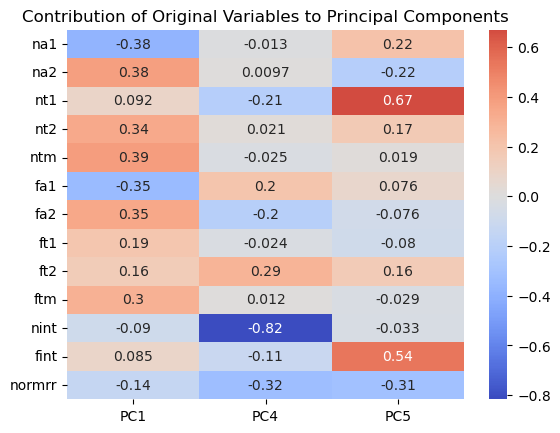

In [203]:
loadings = pca.components_.T  # Transposing so each column corresponds to a PC
loadings_df = pd.DataFrame(loadings[:,[0,3,4]], columns=['PC1', 'PC4', 'PC5'], index=measures)
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title('Contribution of Original Variables to Principal Components')
plt.show()